In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-11 17:09:58.170625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 17:09:58.256790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 17:09:58.256858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 17:09:58.260435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 17:09:58.279234: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-11 17:10:00.581883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 17:10:00.658646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 17:10:00.658820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

""" #feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y) """

# use laser power and velocity as labels
y = y[:, :2]
print("y shape: ", y.shape)

# print max of each column
print("max of each column: ", np.max(y, axis=0))
# normalize y by dividing laser power by max of each column
y = y / np.max(y, axis=0)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587, 2)
max of each column:  [2750   15]


In [3]:

# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
y_encoded = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    y_encoded[:, i] = encode_one_column(y[:, i])
    
# convert to int
y_encoded = y_encoded.astype(int)
y_encoded.shape

(9587, 2)

In [4]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
x = np.concatenate((manta, xiris), axis=0)
y = np.concatenate((y_encoded, y_encoded), axis=0)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x shape:  (19174, 320, 320)
y shape:  (19174, 2)
x_train shape:  (15339, 320, 320)
y_train shape:  (15339, 2)
x_test shape:  (3835, 320, 320)
y_test shape:  (3835, 2)


In [5]:
del manta, xiris, y, y_encoded, x

In [6]:
y_train

array([[3, 0],
       [3, 0],
       [0, 2],
       ...,
       [2, 0],
       [0, 0],
       [2, 1]])

In [23]:
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# Add contrastive and regression head
def add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layer for each task
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 2
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
encoder_with_contrastive_head = add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks)
encoder_with_contrastive_head.summary()

# Compile model
encoder_with_contrastive_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                      loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)],
)
# Fit model
history = encoder_with_contrastive_head.fit(
    x=X_train, 
    y=[y_train[:, 0], y_train[:, 1]],
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_12 (Functional)       (None, 194688)               4800      ['input_9[0][0]']             
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  2492019   ['model_12[0][0]']            
 e)                                                       2                                       
                                                                                                  
 contrastive_output_1 (Dens  (None, 128)                  2492019   ['model_12[0][0]']     

In [29]:
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature
        
    def npairs_loss(self, y_true, y_pred) -> tf.Tensor:
        """Computes the npairs loss between `y_true` and `y_pred`.
        """
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)

        # Expand to [batch_size, 1]
        y_true = tf.expand_dims(y_true, -1)
        # creates a matrix where 1s represent matching labels and 0s represent non-matching labels.
        y_true = tf.cast(tf.equal(y_true, tf.transpose(y_true)), y_pred.dtype)
        y_true /= tf.math.reduce_sum(y_true, 1, keepdims=True)

        loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)

        return tf.math.reduce_mean(loss)

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1) #feature_vectors #
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        
        loss = self.npairs_loss(tf.squeeze(labels), logits)
        return loss 
    #tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# Add contrastive and regression head
def add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layer for each task
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 5
validation_split = 0.2
learning_rate = 0.001
num_tasks = 1   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
encoder_with_contrastive_head = add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks)
encoder_with_contrastive_head.summary()

# Compile model
encoder_with_contrastive_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                      loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)],
)
# Fit model
history = encoder_with_contrastive_head.fit(
    x=X_train, 
    y=[y_train[:,i] for i in range(num_tasks)],
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 320, 320, 1)]     0         
                                                                 
 model_22 (Functional)       (None, 194688)            4800      
                                                                 
 contrastive_output_0 (Dens  (None, 128)               24920192  
 e)                                                              
                                                                 
Total params: 24924992 (95.08 MB)
Trainable params: 24924992 (95.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-11 17:55:30.885192: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB (rounded to 5026201600)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-11 17:55:30.885318: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-11 17:55:30.885359: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 248, Chunks in use: 248. 62.0KiB allocated for chunks. 62.0KiB in use in bin. 6.9KiB client-requested in use in bin.
2024-01-11 17:55:30.885381: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 65, Chunks in use: 64. 40.0KiB allocated for chunks. 39.2KiB in use in bin. 33.8KiB client-requested in use in bin.
2024-01-11 17:55

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

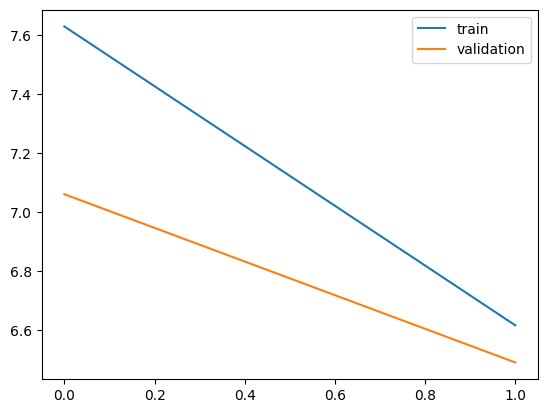

In [24]:
# show training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [9]:
X_train.shape


(15339, 320, 320)

In [10]:
y_train.shape

(15339, 2)

In [11]:
y_train_norm = y_train / np.max(y_train, axis=0)

In [14]:
y_train

array([[3, 0],
       [3, 0],
       [0, 2],
       ...,
       [2, 0],
       [0, 0],
       [2, 1]])

In [16]:
num_levels_P = 4
num_levels_V = 3
# One-hot encode the levels for P
y_train_P = np.eye(num_levels_P)[y_train[:, 0]]

# One-hot encode the levels for V
y_train_V = np.eye(num_levels_V)[y_train[:, 1]]

# Concatenate the one-hot encoded arrays along the second axis
y_train_encoded = np.concatenate((y_train_P, y_train_V), axis=1)

In [17]:
y_train_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [20]:
#NpairsMultilabelLoss

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class NpairsMultilabelLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_multilabel_loss(labels, logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 128
epochs = 20
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
model_with_contrastive_loss = Model(inputs=encoder.input, outputs=encoder.output)

# Compile model with NpairsMultilabelLoss
model_with_contrastive_loss.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                   loss=NpairsMultilabelLoss(temperature=temperature),
)
# Fit model
history = model_with_contrastive_loss.fit(
    x=X_train, 
    y=y_train_encoded,  # Assuming y_train is formatted as needed for a multi-label scenario
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)



Epoch 1/20
96/96 [==============================] - 15s 125ms/step - loss: 4.8400 - val_loss: 4.7910
Epoch 2/20
96/96 [==============================] - 7s 69ms/step - loss: 4.7904 - val_loss: 4.7817
Epoch 3/20
96/96 [==============================] - 7s 74ms/step - loss: 4.7805 - val_loss: 4.7753
Epoch 4/20
96/96 [==============================] - 7s 68ms/step - loss: 4.7753 - val_loss: 4.7743
Epoch 5/20
96/96 [==============================] - 7s 75ms/step - loss: 4.7677 - val_loss: 4.7593
Epoch 6/20
96/96 [==============================] - 7s 70ms/step - loss: 4.7599 - val_loss: 4.7547
Epoch 7/20
96/96 [==============================] - 7s 70ms/step - loss: 4.7563 - val_loss: 4.7541
Epoch 8/20
96/96 [==============================] - 7s 73ms/step - loss: 4.7518 - val_loss: 4.7507
Epoch 9/20
96/96 [==============================] - 6s 68ms/step - loss: 4.7496 - val_loss: 4.7494
Epoch 10/20
96/96 [==============================] - 7s 68ms/step - loss: 4.7509 - val_loss: 4.7440
Epoch 1

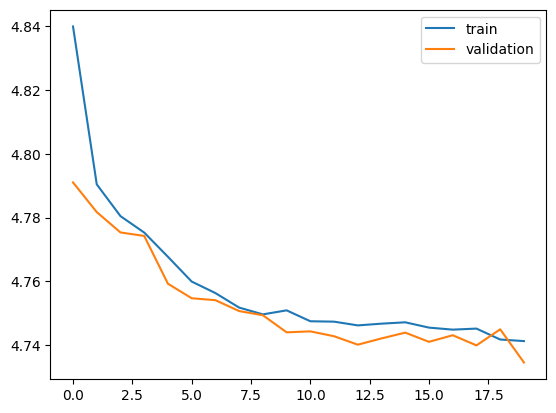

In [22]:
# plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    # add dense layer
    x = Dense(128, activation='relu')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

def add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layers for contrastive tasks
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    # Add dense layers for regression tasks
    regression_outputs = [Dense(1, activation='linear', name=f"regression_output_{i}")(features) for i in range(num_tasks)]

    # Concatenate contrastive and regression outputs
    all_outputs = contrastive_outputs + regression_outputs

    model = Model(inputs=inputs, outputs=all_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 20
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
model_with_contrastive_and_regression = add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks)
model_with_contrastive_and_regression.summary()

# Compile model
model_with_contrastive_and_regression.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                              loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)] + ['mse'] * num_tasks,
)
# Fit model
history = model_with_contrastive_and_regression.fit(
    x=X_train, 
    y=[y_train[:, 0], y_train[:, 1], y_train[:, 0], y_train[:, 1]],  # Add your regression targets accordingly
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_19 (Functional)       (None, 128)                  2492499   ['input_22[0][0]']            
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model_19[0][0]']            
 e)                                                                                               
                                                                                           

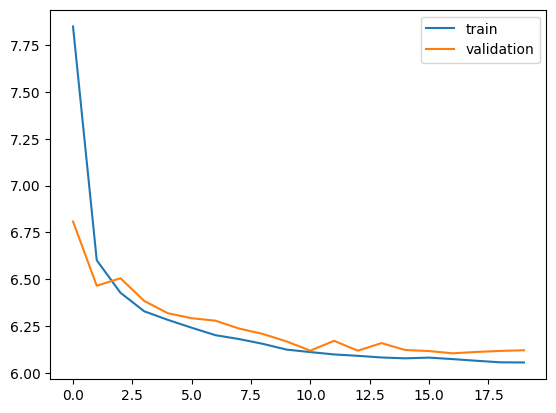

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [24]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

def add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layers for contrastive tasks
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    # Add regression tasks based on contrastive outputs
    regression_outputs = [Dense(1, activation='linear', name=f"regression_output_{i}")(output) for i, output in enumerate(contrastive_outputs)]

    # Concatenate contrastive and regression outputs
    all_outputs = contrastive_outputs + regression_outputs

    model = Model(inputs=inputs, outputs=all_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 20
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
model_with_contrastive_and_regression = add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks)
model_with_contrastive_and_regression.summary()

# Compile model
model_with_contrastive_and_regression.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                              loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)] + ['mse'] * num_tasks,
)
# Fit model
history = model_with_contrastive_and_regression.fit(
    x=X_train, 
    y=[y_train[:, 0], y_train[:, 1], y_train[:, 0], y_train[:, 1]],  # Use contrastive outputs for regression tasks
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_21 (Functional)       (None, 194688)               4800      ['input_24[0][0]']            
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  2492019   ['model_21[0][0]']            
 e)                                                       2                                       
                                                                                                  
 contrastive_output_1 (Dens  (None, 128)                  2492019   ['model_21[0][0]']     

In [25]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        contrastive_loss = tfa.losses.npairs_loss(tf.squeeze(labels), logits)
        return contrastive_loss

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

def add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layers for contrastive tasks
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    # Add regression tasks based on contrastive outputs
    regression_outputs = [Dense(1, activation='linear', name=f"regression_output_{i}")(output) for i, output in enumerate(contrastive_outputs)]

    # Concatenate contrastive and regression outputs
    all_outputs = contrastive_outputs + regression_outputs

    model = Model(inputs=inputs, outputs=all_outputs)
    return model

# Custom metric for contrastive loss
def contrastive_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1)), dtype=tf.float32))

# Custom metric for regression loss (Mean Absolute Error, MAE)
def regression_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 20
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
model_with_contrastive_and_regression = add_contrastive_and_regression_heads(input_shape, encoder, embedding_dim, num_tasks)
model_with_contrastive_and_regression.summary()

# Compile model
model_with_contrastive_and_regression.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                              loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)] + ['mse'] * num_tasks,
                                              metrics={'contrastive_output_0': contrastive_accuracy, 'contrastive_output_1': contrastive_accuracy, 
                                                       'regression_output_0': regression_mae, 'regression_output_1': regression_mae},
)
# Fit model
history = model_with_contrastive_and_regression.fit(
    x=X_train, 
    y=[y_train[:, 0], y_train[:, 1], y_train[:, 0], y_train[:, 1]],  # Use contrastive outputs for regression tasks
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_23 (Functional)       (None, 194688)               4800      ['input_26[0][0]']            
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  2492019   ['model_23[0][0]']            
 e)                                                       2                                       
                                                                                                  
 contrastive_output_1 (Dens  (None, 128)                  2492019   ['model_23[0][0]']     

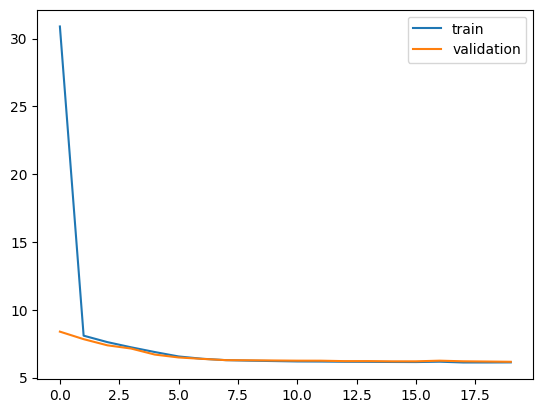

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()